# Generating a dataset for Fraud Analysis


In [2]:
!pip install faker

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 64.7 MB/s eta 0:00:00


In [3]:
import pandas as pd
import numpy as np
from faker import Faker

# Initialisation de Faker
fake = Faker()
np.random.seed(42)

# Nombre de transactions à générer
n_samples = 15_000

# Types de transactions
transaction_types = ["CASH_OUT", "PAYMENT", "CASH_IN", "TRANSFER", "DEBIT"]

# Génération des données
transactions = []
usernames = [fake.user_name() for _ in range(n_samples // 2)]  # Liste d'utilisateurs fictifs

for _ in range(n_samples):
    step = np.random.choice(range(1, 8))
    trans_type = np.random.choice(transaction_types, p=[0.3, 0.3, 0.2, 0.15, 0.05])
    amount = round(np.random.uniform(10, 19999), 2)
    oldbalanceOrig = round(np.random.uniform(0, 25560), 2)
    oldbalanceDest = round(np.random.uniform(0, 15000), 2)  # Initialisation ici
    newbalanceDest = oldbalanceDest  # Nouvelle initialisation pour éviter des erreurs

    isFraud = 0
    isAlertedFraud = 0

    user_orig = np.random.choice(usernames)
    user_dest = np.random.choice(usernames)

    # Assurer la cohérence des transactions où expéditeur et destinataire sont identiques
    if trans_type in ["TRANSFER", "DEBIT"]:
        user_dest = user_orig

    # Règles spécifiques aux fraudes
    if isinstance(step, (np.ndarray, pd.Series)):
        if (step > 4).any():  # Vérifie si au moins une valeur dépasse 4
            isAlertedFraud = 1
    else:
        if step > 4:
            isAlertedFraud = 1

    if trans_type in ["CASH_OUT", "TRANSFER", "DEBIT", "CASH_IN", "PAYMENT"] and np.random.rand() < 0.05:
        isFraud = 1  # 5% des transactions sont frauduleuses
    if trans_type in ["CASH_OUT", "TRANSFER"] and amount > 15000:
        isAlertedFraud = 1  # Les fraudes au-dessus de 15000 sont signalées
    if isFraud and user_orig == user_dest:
        isAlertedFraud = 1  # Usager suspect et fraudeur

    if trans_type == "CASH_IN" and oldbalanceDest == newbalanceDest:
        isFraud = 1  # Un dépôt d’argent doit modifier le solde du destinataire
    if trans_type == "PAYMENT" and oldbalanceDest == newbalanceDest and amount > 0:
        isFraud = 1  # Un paiement doit modifier le solde sauf s'il est annulé

    if isFraud:
        newbalanceDest = oldbalanceDest + np.random.uniform(-amount, amount / 2)  # Simule des fonds partiellement détournés
    else:
        newbalanceDest = oldbalanceDest + amount

    # Gestion des soldes après transaction
    newbalanceOrig = oldbalanceOrig - amount if oldbalanceOrig >= amount else oldbalanceOrig  # Gérer les comptes à découvert

    transactions.append([step, trans_type, user_orig, user_dest, amount, oldbalanceOrig, newbalanceOrig, oldbalanceDest, newbalanceDest, isAlertedFraud, isFraud])

# Création du DataFrame
df_synthetic = pd.DataFrame(transactions, columns=["step", "type", "user_orig", "user_dest", "amount", "oldbalanceOrig", "newbalanceOrig", "oldbalanceDest", "newbalanceDest", "isAlertedFraud", "isFraud"])

# Sauvegarde
df_synthetic.to_csv("synthetic_transactions.csv", index=False)

print("Generated !")


Generated !


### SCENARIOS :

* **Transactions aléatoires avec types variés** : Génération de transactions parmi 5 types (CASH_OUT, PAYMENT, CASH_IN, TRANSFER, DEBIT).
* **Fraude basée sur le temps (step)** : Si step > 4, la transaction est marquée comme suspecte (isAlertedFraud).
* **Fraude aléatoire sur certaines transactions** : 5% des transactions sont frauduleuses (isFraud = 1).
* **Fraude pour montants élevés** : Si le montant (amount) d’une transaction CASH_OUT ou TRANSFER dépasse 15 000, la transaction est signalée comme suspecte.
* **Fraude lorsque l'expéditeur et le destinataire sont identiques** : Toute transaction frauduleuse où user_orig == user_dest est signalée (isAlertedFraud = 1).
* **Fraude sur les transactions sans impact sur le solde du destinataire** :
CASH_IN et PAYMENT sont considérés frauduleux si oldbalanceDest == newbalanceDest.
* **Fraude avec détournement partiel des fonds** : Si isFraud == 1, l’argent peut être partiellement détourné (newbalanceDest modifié de manière aléatoire).
* **Gestion des comptes à découvert** : newbalanceOrig ne devient négatif que si l’ancien solde permet la transaction.

In [4]:
df = pd.read_csv('synthetic_transactions.csv')
df.head()

,step,type,user_orig,user_dest,amount,oldbalanceOrig,newbalanceOrig,oldbalanceDest,newbalanceDest,isAlertedFraud,isFraud
0,7,CASH_IN,amberphillips,tharris,3676.68,19928.90,16252.22,8952.75,7808.836824,1,1
1,5,CASH_IN,qvelazquez,vwolfe,14163.66,526.14,526.14,14548.65,21465.010761,1,1
2,1,PAYMENT,lmartinez,jerrywebb,10499.36,11040.51,541.15,4368.44,-1529.922244,0,1
3,7,PAYMENT,uingram,deborah09,15704.88,5103.66,5103.66,7713.52,6320.768491,1,1
4,5,PAYMENT,torresjeffery,ucobb,275.15,24082.68,23807.53,8449.32,8269.465654,1,1


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   step            15000 non-null  int64  
 1   type            15000 non-null  object 
 2   user_orig       15000 non-null  object 
 3   user_dest       15000 non-null  object 
 4   amount          15000 non-null  float64
 5   oldbalanceOrig  15000 non-null  float64
 6   newbalanceOrig  15000 non-null  float64
 7   oldbalanceDest  15000 non-null  float64
 8   newbalanceDest  15000 non-null  float64
 9   isAlertedFraud  15000 non-null  int64  
 10  isFraud         15000 non-null  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 1.3+ MB


In [6]:
df[(df["isFraud"] == 1) & (df["isAlertedFraud"] == 1)].shape[0]


3512

In [7]:
df[(df["isFraud"] == 1)].shape[0]

7981

In [8]:
isFraud = df[(df["isFraud"] == 1)]

In [9]:
isFraud.head()

,step,type,user_orig,user_dest,amount,oldbalanceOrig,newbalanceOrig,oldbalanceDest,newbalanceDest,isAlertedFraud,isFraud
0,7,CASH_IN,amberphillips,tharris,3676.68,19928.90,16252.22,8952.75,7808.836824,1,1
1,5,CASH_IN,qvelazquez,vwolfe,14163.66,526.14,526.14,14548.65,21465.010761,1,1
2,1,PAYMENT,lmartinez,jerrywebb,10499.36,11040.51,541.15,4368.44,-1529.922244,0,1
3,7,PAYMENT,uingram,deborah09,15704.88,5103.66,5103.66,7713.52,6320.768491,1,1
4,5,PAYMENT,torresjeffery,ucobb,275.15,24082.68,23807.53,8449.32,8269.465654,1,1


In [10]:
naFraud = df[(df["isFraud"] == 0)]
naFraud.head()

,step,type,user_orig,user_dest,amount,oldbalanceOrig,newbalanceOrig,oldbalanceDest,newbalanceDest,isAlertedFraud,isFraud
8,7,TRANSFER,david22,david22,7141.14,7180.69,39.55,8140.44,15281.58,1,0
9,1,CASH_OUT,hannah14,thorntonryan,8473.37,10093.17,1619.80,4402.32,12875.69,0,0
11,1,CASH_OUT,ryan34,smithjustin,6226.23,8311.69,2085.46,10944.09,17170.32,0,0
14,6,CASH_OUT,michaelramos,pbenitez,12091.70,13798.34,1706.64,3045.92,15137.62,1,0
15,3,CASH_OUT,fmccarthy,thomas89,18593.73,20655.56,2061.83,9501.06,28094.79,1,0


In [11]:
isFraud["type"].value_counts()

,count
type,
PAYMENT,4590
CASH_IN,3020
CASH_OUT,207
TRANSFER,121
DEBIT,43


In [12]:
isFraud[(isFraud["isFraud"]==1) & (isFraud["newbalanceDest"]<0)]

,step,type,user_orig,user_dest,amount,oldbalanceOrig,newbalanceOrig,oldbalanceDest,newbalanceDest,isAlertedFraud,isFraud
2,1,PAYMENT,lmartinez,jerrywebb,10499.36,11040.51,541.15,4368.44,-1529.922244,0,1
6,2,PAYMENT,trobinson,huntertheresa,4166.55,14510.42,10343.87,469.70,-1227.230176,0,1
12,1,PAYMENT,crystal58,faulknerkari,19433.55,21698.24,2264.69,10825.94,-7428.957724,0,1
16,4,PAYMENT,ashley85,joseph31,17665.89,8290.26,8290.26,1831.32,-8623.382425,0,1
17,3,PAYMENT,boydelizabeth,leah56,16361.30,22000.27,5638.97,104.28,-10806.061221,0,1
...,...,...,...,...,...,...,...,...,...,...,...
14949,3,PAYMENT,allison57,susanbishop,12945.92,8261.78,8261.78,2667.40,-2421.466063,0,1
14954,4,PAYMENT,jesusboyd,andrew78,5613.95,7277.35,1663.40,541.56,-2107.847520,0,1
14959,2,PAYMENT,erin38,jessica92,16158.96,18625.40,2466.44,7500.19,-4605.163667,0,1
14965,5,CASH_IN,goldenjeremy,ucobb,15651.65,19311.82,3660.17,5412.75,-9570.381666,1,1


In [13]:
strangFraud = isFraud[(isFraud["isFraud"]==1) & (isFraud["newbalanceDest"]<0)]
strangFraud.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1699 entries, 2 to 14990
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   step            1699 non-null   int64  
 1   type            1699 non-null   object 
 2   user_orig       1699 non-null   object 
 3   user_dest       1699 non-null   object 
 4   amount          1699 non-null   float64
 5   oldbalanceOrig  1699 non-null   float64
 6   newbalanceOrig  1699 non-null   float64
 7   oldbalanceDest  1699 non-null   float64
 8   newbalanceDest  1699 non-null   float64
 9   isAlertedFraud  1699 non-null   int64  
 10  isFraud         1699 non-null   int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 159.3+ KB


In [14]:
strangFraud["type"].value_counts()

,count
type,
PAYMENT,993
CASH_IN,632
CASH_OUT,41
TRANSFER,26
DEBIT,7


In [15]:
naFraud[(naFraud["newbalanceDest"]<0)].shape[0]

0

## Setting goals
Dans notre dataset, nous avons identifié des scénarios variés qui correspondent à des cas réalistes de fraude. Pour la modélisation, nous allons nous baser sur ces scénarios afin d'obtenir un modèle le plus précis possible.
Ceci inclut que:
* Nou mettrons en place **un modèle qui correspond aux transactions financières de type mobile money ou agrégateurs de paiement**

* Nous appliquerons **si nécessaire un modèle différent pour certains type de transaction**

* Nous retirerons les **données des comptes destinataires à découvert** notamment lorsqu'une fraude est observée

* Nous créerons une ou plusieurs nouvelles variables pour **faciliter la comprehension des données que l'algorithme ne peut pas comprendre**.

### Nos objectifs:
* Obtenir des modèles capables de prédire avec exactitude (à un pourcentage près) des fraudes
* Avoir un un modèle pour alerter les fraudes


## Preprocessing


In [16]:
#Suppression des fraudes peu normales:
df = df.drop(df[(df["isFraud"]==1) & (df["newbalanceDest"]<0)].index)

In [17]:
df[df["isFraud"]==1].shape[0]

6282

In [18]:
#Recodage des données
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df['enc_type'] = le.fit_transform(df['type'])
df.head()

,step,type,user_orig,user_dest,amount,oldbalanceOrig,newbalanceOrig,oldbalanceDest,newbalanceDest,isAlertedFraud,isFraud,enc_type
0,7,CASH_IN,amberphillips,tharris,3676.68,19928.90,16252.22,8952.75,7808.836824,1,1,0
1,5,CASH_IN,qvelazquez,vwolfe,14163.66,526.14,526.14,14548.65,21465.010761,1,1,0
3,7,PAYMENT,uingram,deborah09,15704.88,5103.66,5103.66,7713.52,6320.768491,1,1,3
4,5,PAYMENT,torresjeffery,ucobb,275.15,24082.68,23807.53,8449.32,8269.465654,1,1,3
5,4,PAYMENT,areed,morganclark,2449.42,12656.72,10207.30,515.83,500.603001,0,1,3


In [19]:
check_type = df[["type","enc_type"]]
check_type

,type,enc_type
0,CASH_IN,0
1,CASH_IN,0
3,PAYMENT,3
4,PAYMENT,3
5,PAYMENT,3
...,...,...
14995,PAYMENT,3
14996,CASH_OUT,1
14997,DEBIT,2
14998,TRANSFER,4


Désormais, les transactions de type:

▶ CASH_IN ===> 0

▶ CASH_OUT ===> 1

▶ DEBIT ===> 2

▶ PAYMENT ===> 3

▶ TRANSFER ===> 4

In [20]:
# Compréhension des transaction incluant ou non les mêmes nom d'utilisateur

df["same_user"] = np.where(df["user_orig"] == df["user_dest"], 1, 0)
check_user = df[["user_orig","user_dest","same_user"]]
check_user


,user_orig,user_dest,same_user
0,amberphillips,tharris,0
1,qvelazquez,vwolfe,0
3,uingram,deborah09,0
4,torresjeffery,ucobb,0
5,areed,morganclark,0
...,...,...,...
14995,lauraharris,perryvictor,0
14996,ycalderon,ericamoreno,0
14997,lpearson,lpearson,1
14998,melissa85,melissa85,1


In [21]:
see_user = df[df["same_user"]==1]
see_user["type"].value_counts()

,count
type,
TRANSFER,2210
DEBIT,720
PAYMENT,2


Nous disposons à présent des variables utiles pour la modélisation. Nous créerons un nouveau dataframe issu de l'ancien à cet effet.

In [22]:
#Dataframe clean pour la modélisation:

data = df.select_dtypes(include=[np.number])
data.head()

,step,amount,oldbalanceOrig,newbalanceOrig,oldbalanceDest,newbalanceDest,isAlertedFraud,isFraud,enc_type,same_user
0,7,3676.68,19928.90,16252.22,8952.75,7808.836824,1,1,0,0
1,5,14163.66,526.14,526.14,14548.65,21465.010761,1,1,0,0
3,7,15704.88,5103.66,5103.66,7713.52,6320.768491,1,1,3,0
4,5,275.15,24082.68,23807.53,8449.32,8269.465654,1,1,3,0
5,4,2449.42,12656.72,10207.30,515.83,500.603001,0,1,3,0


In [23]:
data["isFraud"].value_counts()

,count
isFraud,
0,7019
1,6282


In [24]:
import matplotlib.pyplot as plt
import seaborn as sns

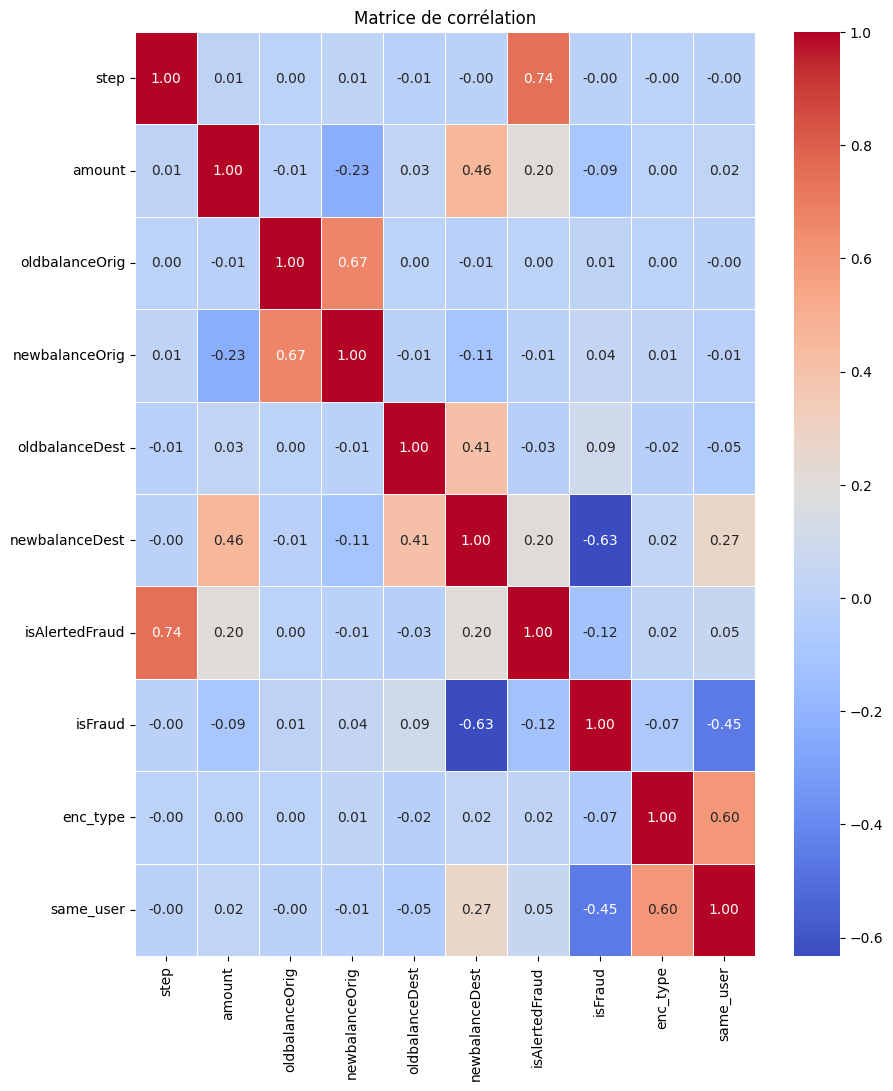

In [25]:
#Création d'une matrice de corrélation

matrice_corr = data.corr()

#Afficher les valeur sous forma de Heatmap
plt.figure(figsize = (10,12))
sns.heatmap(matrice_corr, annot=True, cmap ="coolwarm", fmt = ".2f", linewidths=0.5)
plt.title("Matrice de corrélation")
plt.show()

## Modélisation

* Notre premier modèle permettra de détecter des fraudes tout
partout où il peut en avoir simplement
* Le deuxième servira à détecter des fraudes sur les transactions qui incluent deux comptes différents (PAYMENT, CASH_IN, CASH_OUT)
* Un troisième modèle servira à prédire les alertes de fraudes


1-/ Modèle de détection de fraudes

In [26]:
#Splitter le dataset en ensemble d'entraînement et ensemble de test
from sklearn.model_selection import train_test_split

X = data.drop(columns=["isFraud"])
Y = data["isFraud"]

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

print(f"Taille de l'ensemble d'entrainement: {X_train.shape}")
print(f"Taille de l'ensemble de test: {X_test.shape}")

Taille de l'ensemble d'entrainement: (10640, 9)
Taille de l'ensemble de test: (2661, 9)


In [27]:
#Normalisation des données
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [28]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier

# Définition du modèle XGBoost
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')

# Définition de la grille d'hyperparamètres à tester
param_grid = {
    'n_estimators': [100, 200, 300],       # Nombre d'arbres
    'max_depth': [3, 6, 10],               # Profondeur des arbres
    'learning_rate': [0.01, 0.1, 0.3],     # Taux d'apprentissage
    'subsample': [0.8, 1.0],               # Échantillonnage des données
    'colsample_bytree': [0.8, 1.0],        # Sélection de features par arbre
    'gamma': [0, 0.1, 0.5]                 # Régularisation
}

# Mise en place de GridSearchCV
grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    scoring='accuracy',
    cv=5,  # Cross-validation en 5 parties
    verbose=1,
    n_jobs=-1  # Utilisation de tous les cœurs CPU disponibles
)

# Entraînement de GridSearch
grid_search.fit(X_train_scaled, Y_train)

# Affichage des meilleurs hyperparamètres
print("Meilleurs hyperparamètres :", grid_search.best_params_)

# Récupération du meilleur modèle
best_model = grid_search.best_estimator_


Fitting 5 folds for each of 324 candidates, totalling 1620 fits
Meilleurs hyperparamètres : {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [10:42:12] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [29]:
#Initialisation et entraînement

model = XGBClassifier(colsample_bytree= 1.0, gamma= 0.1, learning_rate= 0.3, max_depth= 3, n_estimators= 200, subsample= 0.8, reg_lambda=5, reg_alpha=2,min_child_weight=5)
model.fit(X_train_scaled, Y_train)  # On entraîne le modèle sur les données normalisées


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=1.0, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.1, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.3, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=5, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [30]:
from sklearn.metrics import accuracy_score, classification_report

# Prédiction sur le test set
Y_pred = best_model.predict(X_test_scaled)

# Évaluation
print(f"Accuracy : {accuracy_score(Y_test, Y_pred):.2f}")
print("Classification Report :\n", classification_report(Y_test, Y_pred))


Accuracy : 1.00
Classification Report :
               precision    recall  f1-score   support

           0       0.99      1.00      1.00      1435
           1       1.00      0.99      1.00      1226

    accuracy                           1.00      2661
   macro avg       1.00      1.00      1.00      2661
weighted avg       1.00      1.00      1.00      2661



In [31]:
#Avec le score de la validation croisée, nous pouvons vérifier si notre modèle ne surapprend pas car le score de précision est très élevé
from sklearn.model_selection import cross_val_score

cv_scores = cross_val_score(model, X_train, Y_train, cv=5, scoring="accuracy")
print(f"Validation croisée (moyenne) : {cv_scores.mean():.4f}")


Validation croisée (moyenne) : 0.9952


**A en croire les cores obtenus, notre modèle de détection (classification) de transactions frauduleuses performe bien. Nous pouvons toutefois le tester sur de nouvelles données pour en avoir le coeur net.**



In [32]:
#from google.colab import drive
#drive.mount('/content/drive')

In [33]:
#import joblib

# Chemin du dossier où sauvegarder les fichiers
#save_path = "/content/drive/MyDrive/Colab Notebooks/models_Fraud_Analysis_and_detection/"

# Sauvegarde du modèle et du scaler avec un nom de fichier correct
#joblib.dump(model, save_path + "fraud_detection_model.pkl")
#joblib.dump(scaler, save_path + "scaler.pkl")

print("✅ Modèle et transformations sauvegardés dans Google Drive !")


✅ Modèle et transformations sauvegardés dans Google Drive !


In [34]:
#Création d'un nouveau dataset


# Nombre de transactions à générer
n_samples = 5_000

# Types de transactions
transaction_types = ["CASH_OUT", "PAYMENT", "CASH_IN", "TRANSFER", "DEBIT"]

# Génération des données
transactions = []
usernames = [fake.user_name() for _ in range(n_samples // 2)]  # Liste d'utilisateurs fictifs

for _ in range(n_samples):
    step = np.random.choice(range(1, 8))
    trans_type = np.random.choice(transaction_types, p=[0.3, 0.3, 0.2, 0.15, 0.05])
    amount = round(np.random.uniform(10, 19999), 2)
    oldbalanceOrig = round(np.random.uniform(0, 25560), 2)
    oldbalanceDest = round(np.random.uniform(0, 15000), 2)  # Initialisation ici
    newbalanceDest = oldbalanceDest  # Nouvelle initialisation pour éviter des erreurs

    isFraud = 0
    isAlertedFraud = 0

    user_orig = np.random.choice(usernames)
    user_dest = np.random.choice(usernames)

    # Assurer la cohérence des transactions où expéditeur et destinataire sont identiques
    if trans_type in ["TRANSFER", "DEBIT"]:
        user_dest = user_orig

    # Règles spécifiques aux fraudes
    if isinstance(step, (np.ndarray, pd.Series)):
        if (step > 4).any():  # Vérifie si au moins une valeur dépasse 4
            isAlertedFraud = 1
    else:
        if step > 4:
            isAlertedFraud = 1

    if trans_type in ["CASH_OUT", "TRANSFER", "DEBIT", "CASH_IN", "PAYMENT"] and np.random.rand() < 0.05:
        isFraud = 1  # 5% des transactions sont frauduleuses
    if trans_type in ["CASH_OUT", "TRANSFER"] and amount > 15000:
        isAlertedFraud = 1  # Les fraudes au-dessus de 15000 sont signalées
    if isFraud and user_orig == user_dest:
        isAlertedFraud = 1  # Usager suspect et fraudeur

    if trans_type == "CASH_IN" and oldbalanceDest == newbalanceDest:
        isFraud = 1  # Un dépôt d’argent doit modifier le solde du destinataire
    if trans_type == "PAYMENT" and oldbalanceDest == newbalanceDest and amount > 0:
        isFraud = 1  # Un paiement doit modifier le solde sauf s'il est annulé

    if isFraud:
        newbalanceDest = oldbalanceDest + np.random.uniform(-amount, amount / 2)  # Simule des fonds partiellement détournés
    else:
        newbalanceDest = oldbalanceDest + amount

    # Gestion des soldes après transaction
    newbalanceOrig = oldbalanceOrig - amount if oldbalanceOrig >= amount else oldbalanceOrig  # Gérer les comptes à découvert

    transactions.append([step, trans_type, user_orig, user_dest, amount, oldbalanceOrig, newbalanceOrig, oldbalanceDest, newbalanceDest, isAlertedFraud, isFraud])

# Création du DataFrame
datest = pd.DataFrame(transactions, columns=["step", "type", "user_orig", "user_dest", "amount", "oldbalanceOrig", "newbalanceOrig", "oldbalanceDest", "newbalanceDest", "isAlertedFraud", "isFraud"])

# Sauvegarde
datest.to_csv("new_transactions.csv", index=False)

print("Generated !")


Generated !


In [35]:
datest.head()

,step,type,user_orig,user_dest,amount,oldbalanceOrig,newbalanceOrig,oldbalanceDest,newbalanceDest,isAlertedFraud,isFraud
0,7,CASH_OUT,ipalmer,claytonkayla,4203.41,15919.82,11716.41,4786.82,8990.230000,1,0
1,6,TRANSFER,davidbell,davidbell,7270.71,250.24,250.24,2672.97,9943.680000,1,0
2,4,TRANSFER,olambert,olambert,17949.81,5528.23,5528.23,13784.02,31733.830000,1,0
3,7,CASH_IN,courtney87,christopherwilliams,1115.11,18772.01,17656.90,14159.64,13788.296714,1,1
4,7,PAYMENT,calvin48,yatesjamie,11441.02,17595.98,6154.96,9267.08,1133.218518,1,1


In [36]:
#Suppression des fraudes peu normales:
datest = datest.drop(datest[(datest["isFraud"]==1) & (datest["newbalanceDest"]<0)].index)

In [37]:
#Recodage des données
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
datest['enc_type'] = le.fit_transform(datest['type'])
datest.head()

,step,type,user_orig,user_dest,amount,oldbalanceOrig,newbalanceOrig,oldbalanceDest,newbalanceDest,isAlertedFraud,isFraud,enc_type
0,7,CASH_OUT,ipalmer,claytonkayla,4203.41,15919.82,11716.41,4786.82,8990.230000,1,0,1
1,6,TRANSFER,davidbell,davidbell,7270.71,250.24,250.24,2672.97,9943.680000,1,0,4
2,4,TRANSFER,olambert,olambert,17949.81,5528.23,5528.23,13784.02,31733.830000,1,0,4
3,7,CASH_IN,courtney87,christopherwilliams,1115.11,18772.01,17656.90,14159.64,13788.296714,1,1,0
4,7,PAYMENT,calvin48,yatesjamie,11441.02,17595.98,6154.96,9267.08,1133.218518,1,1,3


In [38]:
# Compréhension des transaction incluant ou non les mêmes nom d'utilisateur

datest["same_user"] = np.where(datest["user_orig"] == datest["user_dest"], 1, 0)

#Dataframe clean pour la modélisation:

datatest = datest.select_dtypes(include=[np.number])
datatest.head()


,step,amount,oldbalanceOrig,newbalanceOrig,oldbalanceDest,newbalanceDest,isAlertedFraud,isFraud,enc_type,same_user
0,7,4203.41,15919.82,11716.41,4786.82,8990.230000,1,0,1,0
1,6,7270.71,250.24,250.24,2672.97,9943.680000,1,0,4,1
2,4,17949.81,5528.23,5528.23,13784.02,31733.830000,1,0,4,1
3,7,1115.11,18772.01,17656.90,14159.64,13788.296714,1,1,0,0
4,7,11441.02,17595.98,6154.96,9267.08,1133.218518,1,1,3,0


In [39]:
X_datatest = datatest.drop("isFraud", axis=1)
Y_datatest = datatest["isFraud"]

X_datatest = scaler.transform(X_datatest)

# Prédiction
Y_pred_new = model.predict(X_datatest)

# Calculer l'accuracy (ou d'autres métriques)
accuracy = accuracy_score(Y_datatest, Y_pred_new)
print(f"Accuracy sur les nouvelles données : {accuracy:.4f}")

# Afficher un rapport détaillé
print("\nClassification Report :\n", classification_report(Y_datatest, Y_pred_new))


Accuracy sur les nouvelles données : 0.9964

Classification Report :
               precision    recall  f1-score   support

           0       0.99      1.00      1.00      2427
           1       1.00      0.99      1.00      1991

    accuracy                           1.00      4418
   macro avg       1.00      1.00      1.00      4418
weighted avg       1.00      1.00      1.00      4418



**Notre modèle fonctionne également bien sur de nouvelles données.** 🏆

2-/ Modèle de détection des fraudes sur les transactions qui incluent deux comptes différents (PAYMENT, CASH_IN, CASH_OUT)

In [40]:
set_model2=data[data["same_user"]==0]
set_model2.head()

,step,amount,oldbalanceOrig,newbalanceOrig,oldbalanceDest,newbalanceDest,isAlertedFraud,isFraud,enc_type,same_user
0,7,3676.68,19928.90,16252.22,8952.75,7808.836824,1,1,0,0
1,5,14163.66,526.14,526.14,14548.65,21465.010761,1,1,0,0
3,7,15704.88,5103.66,5103.66,7713.52,6320.768491,1,1,3,0
4,5,275.15,24082.68,23807.53,8449.32,8269.465654,1,1,3,0
5,4,2449.42,12656.72,10207.30,515.83,500.603001,0,1,3,0


In [41]:
set_model2["enc_type"].value_counts()

,count
enc_type,
1,4386
3,3595
0,2388


In [42]:
X2_train = set_model2.drop(columns=["isFraud"])
Y2_train = set_model2["isFraud"]

X2_train, X2_test, Y2_train, Y2_test = train_test_split(X2_train, Y2_train, test_size=0.2, random_state=42)

#Normalisation des données
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X2_train_scaled = scaler.fit_transform(X2_train)
X2_test_scaled = scaler.transform(X2_test)

print(f"Taille de l'ensemble d'entrainement: {X2_train.shape}")
print(f"Taille de l'ensemble de test: {X2_test.shape}")

Taille de l'ensemble d'entrainement: (8295, 9)
Taille de l'ensemble de test: (2074, 9)


In [43]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
#from sklearn.metrics import classification_report, accuracy_score

# Définition de la grille d'hyperparamètres à tester
param_grid = {
    'n_estimators': [100, 200, 300],  # Nombre d'arbres
    'max_depth': [None, 10, 20, 30],  # Profondeur maximale des arbres
    'min_samples_split': [2, 5, 10],  # Nombre minimum d’échantillons requis pour diviser un nœud
    'min_samples_leaf': [1, 2, 4],    # Nombre minimum d’échantillons dans une feuille
    'max_features': ['sqrt', 'log2'], # Nombre de caractéristiques à considérer
    'bootstrap': [True, False]        # Échantillonnage avec ou sans remplacement
}

# Instanciation du modèle
fraud_payment_model = RandomForestClassifier(random_state=42)

# Mise en place de GridSearchCV
grid_search = GridSearchCV(
    estimator=fraud_payment_model,
    param_grid=param_grid,
    scoring='f1',  # Utilisation du F1-score pour tenir compte du déséquilibre potentiel des classes
    cv=3,  # Validation croisée en 3 parties pour limiter le temps de calcul
    verbose=2,
    n_jobs=-1,  # Utilisation de tous les cœurs CPU disponibles
    return_train_score=True
)

# Entraînement de GridSearch
grid_search.fit(X2_train_scaled, Y2_train)

# Affichage des meilleurs hyperparamètres
print("\n Meilleurs hyperparamètres :", grid_search.best_params_)

# Récupération du meilleur modèle
best_model = grid_search.best_estimator_

# Évaluation sur le jeu de test
y_pred = best_model.predict(X2_test_scaled)

# Affichage des résultats
print("\n Rapport de classification :\n", classification_report(Y2_test, y_pred))
print(f" Accuracy du modèle optimisé : {accuracy_score(Y2_test, y_pred):.4f}")


Fitting 3 folds for each of 432 candidates, totalling 1296 fits

 Meilleurs hyperparamètres : {'bootstrap': False, 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 300}

 Rapport de classification :
               precision    recall  f1-score   support

           0       0.99      1.00      0.99       840
           1       1.00      0.99      1.00      1234

    accuracy                           0.99      2074
   macro avg       0.99      1.00      0.99      2074
weighted avg       0.99      0.99      0.99      2074

 Accuracy du modèle optimisé : 0.9942


In [45]:
import joblib
#Chemin du dossier où sauvegarder les fichiers
save_path = "/content/drive/MyDrive/Colab Notebooks/models_Fraud_Analysis_and_detection/"

# Sauvegarde du modèle et du scaler avec un nom de fichier correct
joblib.dump(best_model, save_path + "fraudulous_payment_detection_model.pkl")


['/content/drive/MyDrive/Colab Notebooks/models_Fraud_Analysis_and_detection/fraudulous_payment_detection_model.pkl']

In [50]:
# Chargement du modèle et du scaler
model_payment = joblib.load(save_path + "fraudulous_payment_detection_model.pkl")

print("Modèle chargé avec succès !")


Modèle et scaler chargés avec succès !


In [46]:
datest['type'].value_counts()

,count
type,
CASH_OUT,1514
PAYMENT,1150
TRANSFER,759
CASH_IN,753
DEBIT,242


In [47]:
datatest['enc_type'].value_counts()

,count
enc_type,
1,1514
3,1150
4,759
0,753
2,242


In [49]:
model2test = datatest[(datatest["same_user"]==0)]
model2test.head()

,step,amount,oldbalanceOrig,newbalanceOrig,oldbalanceDest,newbalanceDest,isAlertedFraud,isFraud,enc_type,same_user
0,7,4203.41,15919.82,11716.41,4786.82,8990.230000,1,0,1,0
3,7,1115.11,18772.01,17656.90,14159.64,13788.296714,1,1,0,0
4,7,11441.02,17595.98,6154.96,9267.08,1133.218518,1,1,3,0
7,5,9960.65,10610.42,649.77,14762.72,17827.869756,1,1,3,0
10,3,4367.42,8027.50,3660.08,10240.07,14607.490000,0,0,1,0


In [52]:
model2test = model2test[model2test["newbalanceDest"] >= 0]


In [53]:
#Tester le modèle de classification des transaction incluant des utilisateurs différents
X_set = model2test.drop("isFraud", axis=1)
Y_set = model2test["isFraud"]

X_set = scaler.transform(X_set)

# Prédiction
Y_predictions = model_payment.predict(X_set)

# Calculer l'accuracy (ou d'autres métriques)
accuracy = accuracy_score(Y_set, Y_predictions)
print(f"Accuracy sur les nouvelles données : {accuracy:.4f}")

# Afficher un rapport détaillé
print("\nClassification Report :\n", classification_report(Y_set, Y_predictions))

Accuracy sur les nouvelles données : 0.9936

Classification Report :
               precision    recall  f1-score   support

           0       0.99      1.00      0.99      1455
           1       1.00      0.99      0.99      1960

    accuracy                           0.99      3415
   macro avg       0.99      0.99      0.99      3415
weighted avg       0.99      0.99      0.99      3415



Notre modèle de détection des transactions CASH_IN, PAYMENT et CASH_OUT frauduleux fonctionne avec approximativement la même performance sur de nouvelles données.